In [1]:
import math, sys, os, torch, torchvision
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

print("CUDA version:", torch.version.cuda)



Using gpu: True 
CUDA version: 11.8


Feature batch shape: torch.Size([4, 3, 284, 284])
Labels batch shape: torch.Size([4])


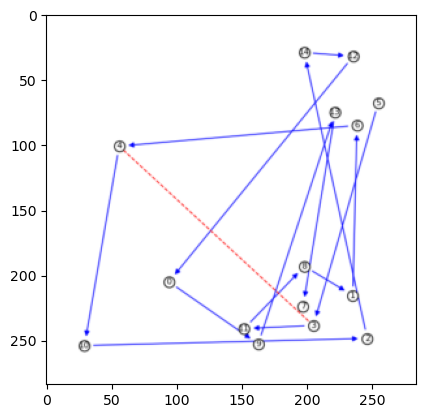

Label: 1


In [2]:
# load model
from models.VisualScoringModel import VisualScoringModel
import src.config as cfg
from torchvision import datasets, transforms
from src.data_loader import load_data

image_size = cfg.image_size
# batch_size = cfg.batch_size
batch_size = 4
train_ratio = cfg.train_ratio

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

data_path = cfg.DATA_DIR

input_shape = (3, image_size[0], image_size[1])

model = VisualScoringModel(input_shape=input_shape).to(device)

train_loader, test_loader = load_data(
    data_path=data_path,
    batch_size=batch_size,
    transform=transform,
    train_ratio=train_ratio,
    image_size=image_size,
    num_workers=0,
)

# --- Check DataLoader ---
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

img = img.permute(1, 2, 0).cpu().numpy()

import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()
print(f"Label: {label}")


In [3]:
from models.VisualScoringModel import train_model
train_model(
    model,
    train_loader,
    test_loader,
    num_epochs=10,
    device=device,
    learning_rate=1e-3,
)


Epoch 1/10 [Train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/10 [Train]: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Epoch 1: Train Loss = 44.1983, Train Acc = 45.83%
           Test Loss  = 2.3400, Test Acc  = 33.33%



Epoch 2/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 16.20it/s]


Epoch 2: Train Loss = 3.6807, Train Acc = 54.17%
           Test Loss  = 4.9159, Test Acc  = 33.33%



Epoch 3/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 16.06it/s]


Epoch 3: Train Loss = 1.5178, Train Acc = 54.17%
           Test Loss  = 2.5031, Test Acc  = 33.33%



Epoch 4/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 15.32it/s]


Epoch 4: Train Loss = 0.8972, Train Acc = 58.33%
           Test Loss  = 1.1197, Test Acc  = 33.33%



Epoch 5/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 16.17it/s]


Epoch 5: Train Loss = 0.6242, Train Acc = 66.67%
           Test Loss  = 0.6850, Test Acc  = 58.33%



Epoch 6/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 16.47it/s]


Epoch 6: Train Loss = 0.5531, Train Acc = 72.92%
           Test Loss  = 0.6455, Test Acc  = 66.67%



Epoch 7/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 16.25it/s]


Epoch 7: Train Loss = 0.7091, Train Acc = 54.17%
           Test Loss  = 1.1047, Test Acc  = 33.33%



Epoch 8/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 16.01it/s]


Epoch 8: Train Loss = 0.5502, Train Acc = 70.83%
           Test Loss  = 0.8775, Test Acc  = 33.33%



Epoch 9/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 16.06it/s]


Epoch 9: Train Loss = 0.4552, Train Acc = 85.42%
           Test Loss  = 0.8489, Test Acc  = 33.33%



Epoch 10/10 [Train]: 100%|██████████| 12/12 [00:00<00:00, 15.61it/s]


Epoch 10: Train Loss = 0.3575, Train Acc = 97.92%
           Test Loss  = 0.7696, Test Acc  = 33.33%



In [4]:
# Hook GradCAM to conv3
import cv2
from models.VisualScoringModel import GradCAM
# Ensure model is in eval mode
model.eval()
gradcam = GradCAM(model, model.conv3)

input_tensor = train_features[0].unsqueeze(0).to(device)  # Add batch dimension

# Generate heatmap for class 2
heatmap = gradcam(input_tensor, class_index=1)

# Resize to match input
heatmap_resized = cv2.resize(heatmap, (84, 84))
heatmap_resized = (heatmap_resized * 255).astype(np.uint8)
colored_heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Overlay on input (grayscale to RGB)
input_image = input_tensor[0, 0].cpu().numpy()
input_image = cv2.cvtColor((input_image * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

# resize to match input
colored_heatmap = cv2.resize(colored_heatmap, (284, 284))

print("Input Image shape:", input_image.shape)
print("Heatmap shape:", colored_heatmap.shape)

overlay = cv2.addWeighted(input_image, 0.5, colored_heatmap, 0.5, 0)

# Save or show the result
cv2.imwrite("gradcam_overlay.png", overlay)

c:\Users\rabas\anaconda3\envs\VRP\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Input Image shape: (284, 284, 3)
Heatmap shape: (284, 284, 3)


True